### Re-project, buffer, dissolve and intersect birds to Utah's major streams

We are going to buffer major streams to 300 feet and clip bird occurrences to that buffer. Thus, we want to re-project our data to a crs that minimizes horizontal distortion.

Use re-projected data to buffer and dissolve major streams. Overlay the results with the birds layer and intersect them. The resulting bird layer will be the main layer used in our web map.

Notebook by Zac Stanley for New Maps Plus - MAP674

#### Initialize python libraries

In [5]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# change default max columns
pd.set_option('display.max_columns', None)

# change default figure size
plt.rcParams['figure.figsize'] = (15,12)

#### Import local datasets that have been explored and refined

In [6]:
#utah major streams
utah_major_streams = gpd.read_file ("./data/utah_major_streams.geojson")

# sw_birds
sw_birds = gpd.read_file("./data/sw_birds.geojson")

#### Check CRS of each object

In [7]:
# utah_major_streams
utah_major_streams.crs

{'init': 'epsg:4326'}

In [8]:
# sw_birds
sw_birds.crs

{'init': 'epsg:4326'}

#### Re-project layers that spatial analysis will performed on

In [9]:
# set a variable with parameters for USA Contiguous Equidistant
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject and assign to new variables
streams_prj = utah_major_streams.to_crs(project_params)
birds_prj = sw_birds.to_crs(project_params)

#### Plot streams_prj

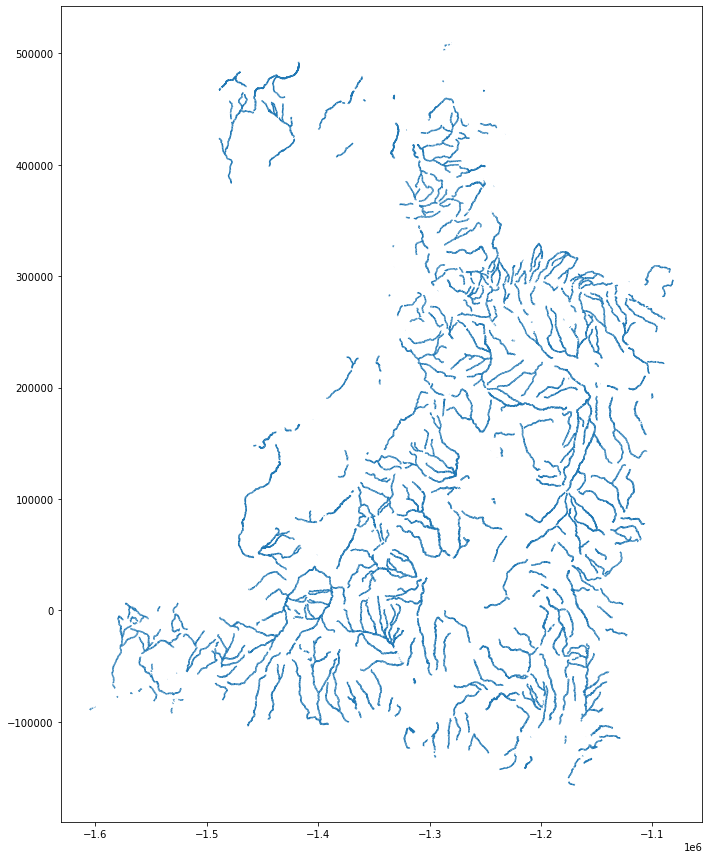

In [10]:
# plot streams
streams_prj.plot(figsize=(15,15));

#### Plot birds_prj

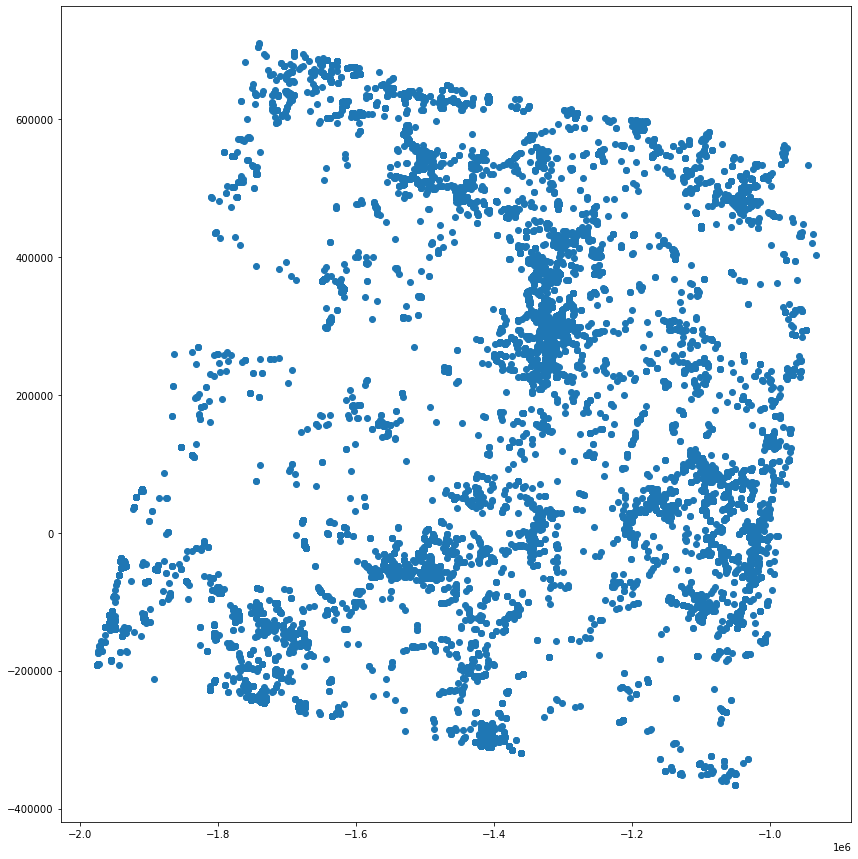

In [11]:
birds_prj.plot(figsize=(15,15));

#### Plot streams and bird occurrences together

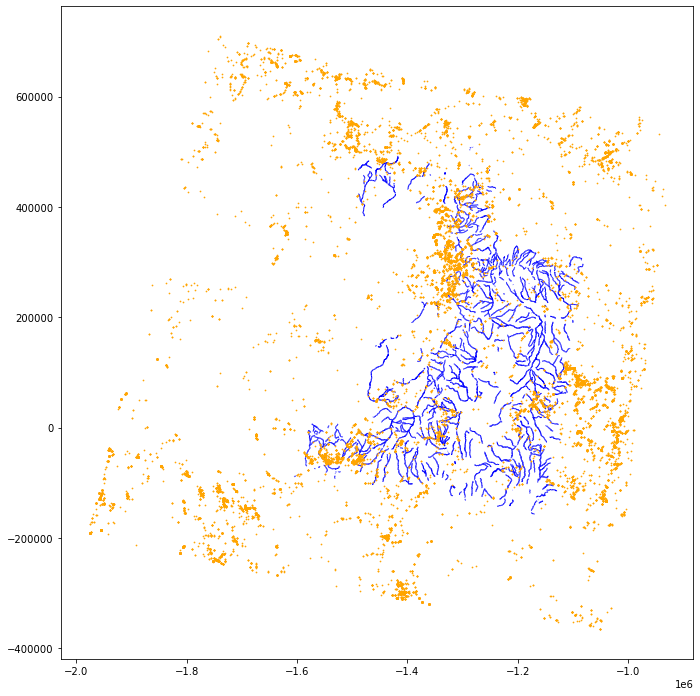

In [12]:
# plot all bird occurences and major streams in the state of Utah 
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=.5);
streams_prj.plot(ax=ax, color='blue', zorder=1, linewidth=1);

#### Buffers streams

In [13]:
# now let's buffer the streams to 300 feet which is the minimum recommendation for good bird habitat along riparian corridors
# we know the units are in meters so.......300 feet = 91.44 meters
# create a new column in streams and give it the result of our buffer operation
streams_prj['buffer'] = streams_prj.buffer(91.44)

#### Make new buffered column the active geometry

In [14]:
streams_prj = streams_prj.set_geometry('buffer')

# check what column geometry is referencing
print(streams_prj.geometry.name) # buffer

buffer


#### Plot buffered streams and bird occurrences

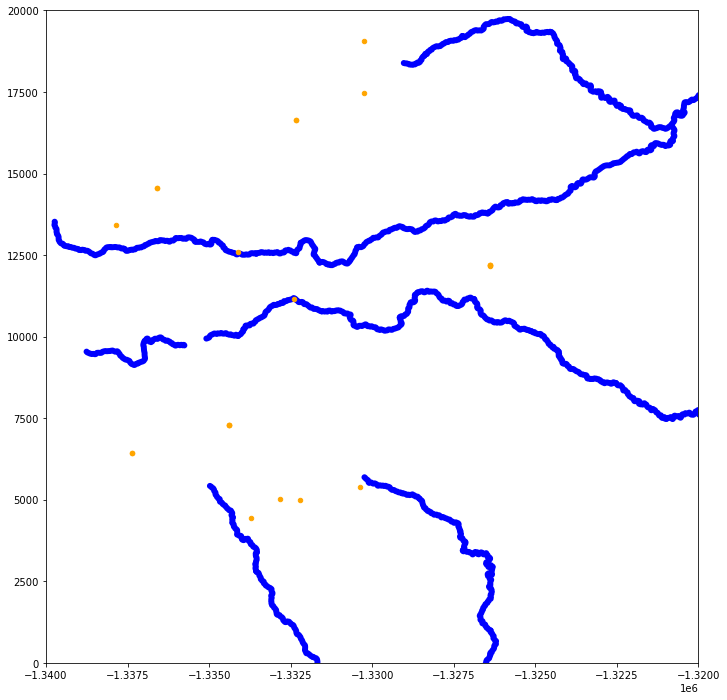

In [15]:
# verify that major streams now have buffer
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=20);
streams_prj.plot(ax=ax, color='blue', zorder=1);

# modify limits to check that buffers are displayed, confirmed
ax.set(xlim=(-1340000,-1320000), ylim=(0,20000));

#### Create polygons from stream buffers for clipping mask

In [16]:
utah_streams_buffered = streams_prj.geometry.unary_union

#### Clip birds_prj to buffered streams

In [17]:
utah_riparian_birds = birds_prj[birds_prj.geometry.intersects(utah_streams_buffered)]  

#### Inspect utah_riparian_birds object

In [18]:
utah_riparian_birds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 598 entries, 3 to 27867
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   field_1                 598 non-null    object  
 1   individualCount         598 non-null    object  
 2   occurrenceStatus        598 non-null    object  
 3   year                    598 non-null    object  
 4   month                   598 non-null    object  
 5   day                     598 non-null    object  
 6   stateProvince           598 non-null    object  
 7   county                  598 non-null    object  
 8   locality                598 non-null    object  
 9   decimalLatitude         598 non-null    float64 
 10  decimalLongitude        598 non-null    float64 
 11  scientificName          598 non-null    object  
 12  vernacularName          598 non-null    object  
 13  verbatimScientificName  598 non-null    object  
 14  geometry        

#### Plot buffered streams and utah_riparian_birds

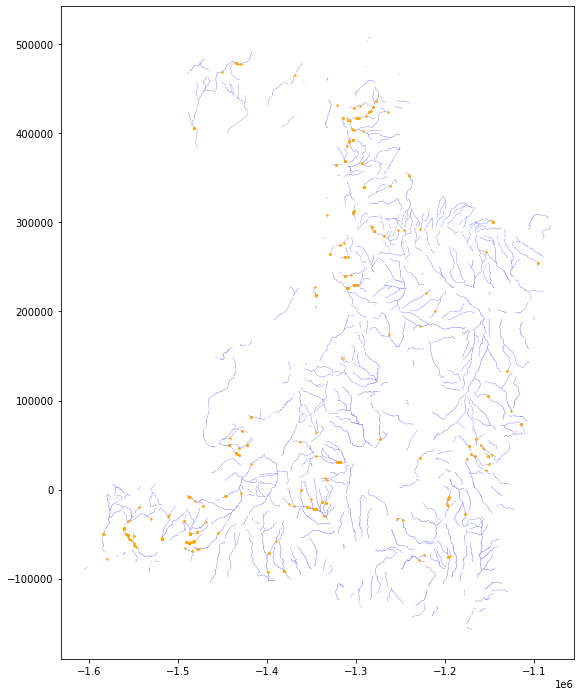

In [19]:
# plot all bird occurences and major streams in the state of Utah 
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

utah_riparian_birds.plot(ax=ax, color='orange', zorder=2, markersize=2);
streams_prj.plot(ax=ax, color='blue', zorder=1, linewidth=10);

#### Reproject  to WGS84 before outputting to geoJSON

In [20]:
utah_riparian_birds_4326 = utah_riparian_birds.to_crs('+proj=longlat +datum=WGS84 +no_defs')

In [21]:
utah_riparian_birds_4326.crs

'+proj=longlat +datum=WGS84 +no_defs'

#### Write utah_riparian_birds to geoJSON

In [23]:
utah_riparian_birds_4326.to_file("./data/utah_riparian_birds.geojson", driver='GeoJSON')